In [1]:
import urllib.request 
import tsplib95       
import math           
import random          
import numpy as np
import networkx as nx
from pyvis.network import Network
import timeit


import matplotlib.pyplot as plt
import matplotlib.animation  as animation
%matplotlib widget
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [2]:
file = "swiss42.tsp" 
urllib.request.urlretrieve("http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/swiss42.tsp.gz", file + '.gz')
!gzip -d swiss42.tsp.gz 

gzip: swiss42.tsp already exists;	not overwritten


In [3]:
# Data loading and problem object generation
problem = tsplib95.load(file)
# Nodes
Nodes = list(problem.get_nodes())
# Edges
Edges = list(problem.get_edges())

## Graph visualization

In [4]:

#to create and save the graph in your local machine uncomment the following:
'''
# Instance of  graph in NetworkX for html visualization
G = nx.Graph()
net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white')
net.repulsion()
#-----------------
#graph configuration
#add nodes
for node in Nodes:
    G.add_node(node)
# Add edges
for edge in Edges:
    node_origen, node_destiny = edge
    G.add_edge(node_origen, node_destiny)
#-----------------
# graph visualization
#add node labels to graph visualization
for node in G.nodes:
    net.add_node(node, label=str(node))
#add edges labels to graph visualization
for edges in G.edges:
    net.add_edge(edges[0], edges[1])
#-----------------
# show graph
#save graph:
# net.show("TSP_general_problema_representation.html")

'''
# plot graph:
display(HTML("multimedia/TSP_general_problema_representation.html"))

## Create the functions for visual representation

In [5]:
#matplotlib static representation

def matplotlib_representation(my_solution, fig_title, seed = 42):
    solution = my_solution.copy()
    solution.append(solution[0])
    G = nx.Graph()
    # Add nodes
    for node in problem.get_nodes():
        G.add_node(node)
    # Get the position of nodes for representation
    pos = nx.spring_layout(G, seed = seed)
    # Create the figure and axes for Matplotlib
    fig, ax = plt.subplots(figsize=(10, 7))
    fig.suptitle(fig_title)
    nx.draw(G, pos, ax=ax, with_labels=True, nodelist=solution, node_size=10, node_color="red")
    for i in range(len(solution) - 1):
        source_node = solution[i]
        target_node = solution[i + 1]
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=[(source_node, target_node)], edge_color="blue", width=.5)
    plt.show()
#--------------------------------------------------------------------------------------------------------

#matplotlib animation, following the traveler
def animate_TSP(solution, 
               my_distance, 
               fig_title, 
               proporcionality_dist_coeff = .1, 
               save = None, 
               seed = 42, 
               interval_ = 50, 
               repeat_saved = False):
    
    my_solution = solution.copy()
    my_solution.append(my_solution[0])
    my_graph = nx.Graph()
    for node in Nodes:
        my_graph.add_node(node)
        
    my_pos = nx.spring_layout(my_graph, seed = seed)
    my_coordinates, acc_distances = [], []
    fract_distance = 0
    
    for i in range(len(my_solution)-1):
        distance_n =  distance(my_solution[i], my_solution[i+1])
        x_origen, y_origen = my_pos[my_solution[i]]
        x_destiny, y_destiny = my_pos[my_solution[i+1]]
        ranges = int(round(distance_n*proporcionality_dist_coeff, 0)+1)
        x = np.linspace(x_origen, x_destiny, ranges)
        y = np.linspace(y_origen, y_destiny, ranges)
        increment = distance_n/ranges
        my_distances = []
        
        for i in range(ranges):
            fract_distance += increment
            my_distances.append(fract_distance)
            
        acc_distances.extend(my_distances)    
        my_coordinates.extend(list(zip(x,y))) 
        
    my_fig, my_ax = plt.subplots(figsize = (10,5))
    
    my_fig.suptitle(fig_title)
    my_ax.set_title('Distance = 0')
    nx.draw(my_graph, my_pos, ax = my_ax, with_labels=True, nodelist = my_solution, node_size = 200, node_color = 'coral', font_color = 'k' ,alpha = .5)
    
    for i in range(len(my_solution) - 1):
        my_source_node = my_solution[i]
        my_target_node = my_solution[i + 1]
        nx.draw_networkx_edges(my_graph, my_pos, ax = my_ax, edgelist=[(my_source_node, my_target_node)], edge_color = 'skyblue', width = 1)
    my_point, = my_ax.plot(my_coordinates[0][0], my_coordinates[0][1],  'o', color = 'k')
    def upD_point(i):
        my_new_x, my_new_y = my_coordinates[i]  
        my_point.set_data(my_new_x, my_new_y)
        my_ax.set_title(f'Distance = {int(round(acc_distances[i]))}')
        return my_point,my_ax
        
    duration = int(my_distance/interval_)
    my_animation = animation.FuncAnimation(my_fig, upD_point, frames = len(my_coordinates), interval = duration, repeat = False)
    if save:
        # save as .gif
        my_animation_2 = animation.FuncAnimation(my_fig, upD_point, frames = len(my_coordinates), interval = duration, repeat = repeat_saved)
        writer = animation.PillowWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
        my_animation_2.save(f'{save}.gif', writer=writer)
    return my_animation


## Create the relevant feasibility functions for comparing different solutions based on the total distance:

In [6]:
def distance(a, b):
    return problem.get_weight(a, b)

def total_distance(solution):
    first_and_last = distance(solution[0], solution[-1])
    nearly_total_distance = sum([distance(*solution[i:i+2]) for i in range(len(solution) - 1)])
    return first_and_last + nearly_total_distance

def create_solution(nodes):
    solution = [nodes[0]]
    for n in nodes[1:]:
        solution = solution + [random.choice(list(set(nodes) - set({nodes[0]}) - set(solution)))]
    return solution


## Testing Random Search

In [7]:
# we will be initializing a dictionary in order to collect all the potential solutions, and features per solution such as distance and performance (time)
solution_collector = []

Random search algorithms are heuristic methods that utilize randomness to explore the solution space in search of acceptable or even optimal solutions for a given problem. Unlike deterministic algorithms that follow a predefined strategy, random search algorithms introduce random elements into their search process to try to avoid getting stuck in local minima and explore different regions of the solution space.

Random search algorithms do not guarantee finding the best solution in every run, as their performance can vary depending on random factors and the problem's structure. However, they can be effective in complex problems where exact methods are inefficient or impractical due to the large number of possible solutions.

In [8]:
def random_search(problem, N, return_distance = False):
    # N is the number of iterations
    Nodes = list(problem.get_nodes())

    best_solution = []                              # Initialize with a high value
    best_distance = float('inf')                    # Initialize with a high value

    for i in range(N):                              # Stopping criterion: repeat N times, but other criteria can be included
        solution = create_solution(Nodes)           # Generate a random solution
        distance = total_distance(solution)         # Calculate the objective value (total distance)

        if distance < best_distance:                # Compare with the best obtained so far
            best_solution = solution
            best_distance = distance

    if not return_distance:
        return best_solution
    return best_solution, best_distance


In [9]:
solution_random_search, distance_random_search = random_search(problem, 50000, return_distance = True)
print("Best solution:", solution_random_search)
print("Distance     :", distance_random_search)

Best solution: [0, 35, 3, 16, 32, 30, 31, 10, 25, 12, 18, 14, 6, 20, 28, 33, 34, 19, 13, 17, 37, 15, 7, 5, 41, 11, 4, 22, 9, 39, 29, 8, 21, 26, 23, 40, 24, 38, 1, 36, 27, 2]
Distance     : 3470


In [10]:
time_random_search = timeit.timeit(lambda: random_search(problem, 50000), number=5)

In [11]:
time_random_search

45.97957179998048

In [12]:
solution_collector.append({'Algorithm':'random_search', 'Mean_exe_time':time_random_search, 'Distance':distance_random_search})
solution_collector

[{'Algorithm': 'random_search',
  'Mean_exe_time': 45.97957179998048,
  'Distance': 3470}]

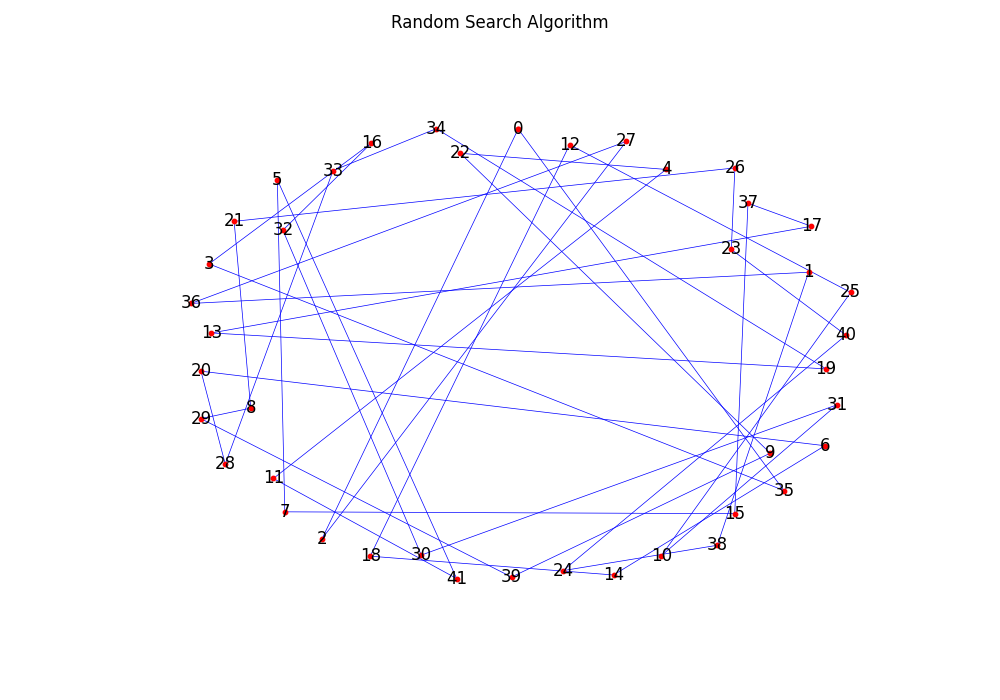

In [13]:
matplotlib_representation(solution_random_search, 'Random Search Algorithm')

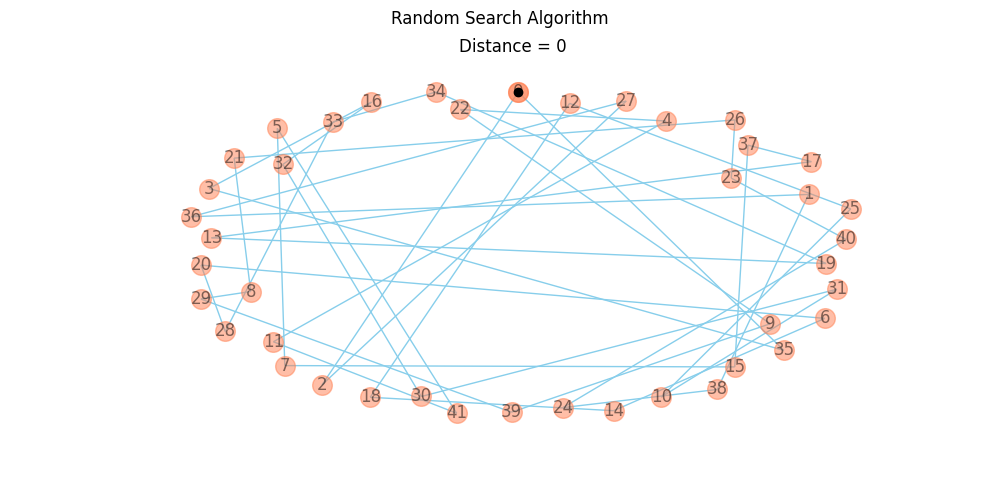

In [14]:
#to save and polt animation in local machine:
# animate_TSP (solution_random_search, distance_random_search, 'Random Search Algorithm', save = 'Random_search_anim', repeat_saved = True)
#----------------------------------------------------
# to plot animation in jupyter:
animate_TSP (solution_random_search, distance_random_search, 'Random Search Algorithm')

## Testing Nearest Neighbor

The nearest neighbor algorithm is a heuristic method used to solve optimization problems, particularly the Traveling Salesman Problem (TSP). In this algorithm, a starting point is chosen, and then at each step, the nearest unvisited city is added to the tour. This process continues until all cities are visited. The algorithm may not always find the optimal solution but tends to provide relatively quick solutions.

In [15]:
def generate_neighbor(solution, return_distance = False):
    best_solution = []
    best_distance = 10e100
    for i in range(1, len(solution) - 1):        
        for j in range(i + 1, len(solution)):
            neighbor = solution[:i] + [solution[j]] + solution[i + 1:j] + [solution[i]] + solution[j + 1:]
            neighbor_distance = total_distance(neighbor)
            if neighbor_distance <= best_distance:
                best_distance = neighbor_distance
                best_solution = neighbor
                
    if not return_distance:
        return best_solution
    return best_solution, best_distance

In [16]:
solution_generate_neighbor, distance_generate_neighbor = generate_neighbor(solution_random_search, return_distance = True)
print("Best solution:", solution_generate_neighbor)
print("Distance     :", distance_generate_neighbor)

Best solution: [0, 35, 36, 16, 32, 30, 31, 10, 25, 12, 18, 14, 6, 20, 28, 33, 34, 19, 13, 17, 37, 15, 7, 5, 41, 11, 4, 22, 9, 39, 29, 8, 21, 26, 23, 40, 24, 38, 1, 3, 27, 2]
Distance     : 3128


In [17]:
time_generate_neighbor = timeit.timeit(lambda: generate_neighbor(solution_random_search), number=5)

In [18]:
time_generate_neighbor

0.30841300007887185

In [19]:
solution_collector.append({'Algorithm':'Nearest Neighbor', 'Mean_exe_time':time_generate_neighbor, 'Distance':distance_generate_neighbor})
solution_collector

[{'Algorithm': 'random_search',
  'Mean_exe_time': 45.97957179998048,
  'Distance': 3470},
 {'Algorithm': 'Nearest Neighbor',
  'Mean_exe_time': 0.30841300007887185,
  'Distance': 3128}]

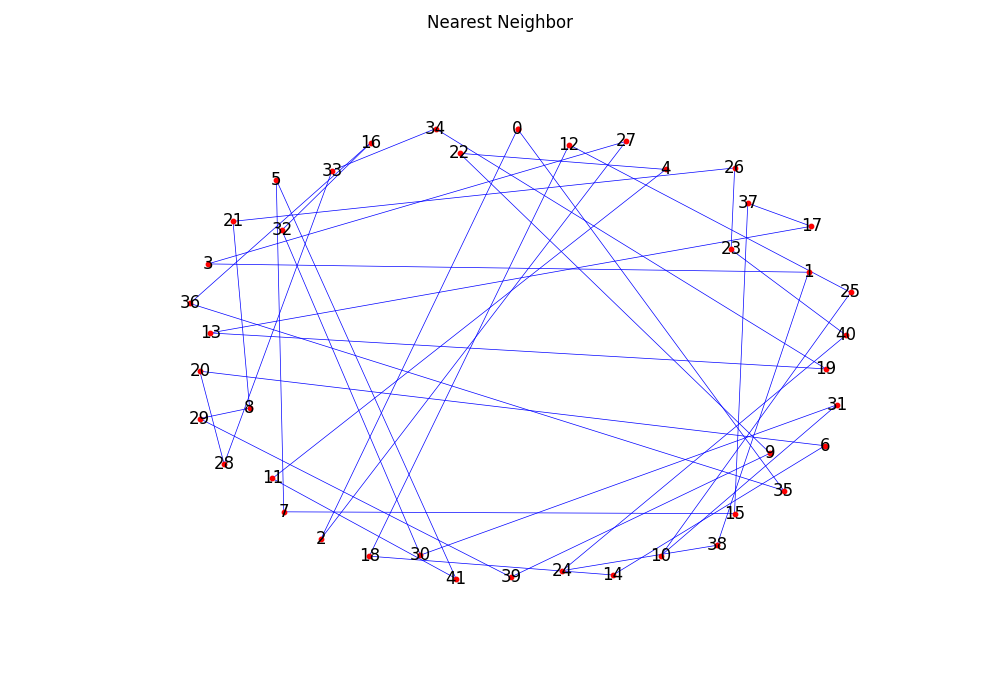

In [20]:
matplotlib_representation(solution_generate_neighbor, 'Nearest Neighbor')

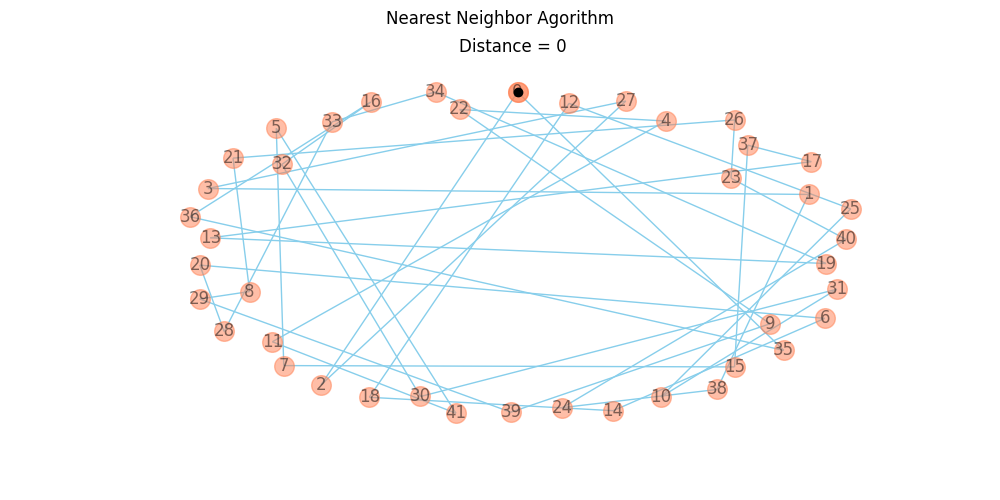

In [21]:
#to save and polt animation in local machine:
# animate_TSP (solution_generate_neighbor, distance_generate_neighbor, 'Nearest Neighbor Agorithm', save = 'Nearest_Neighbor_anim', repeat_saved = True)
#----------------------------------------------------
# to plot animation in jupyter:
animate_TSP (solution_generate_neighbor, distance_generate_neighbor, 'Nearest Neighbor Agorithm')

## Testing Local search 

Local search is a heuristic optimization approach that starts with an initial solution and iteratively explores neighboring solutions to find an improved solution within a local region of the solution space. It involves making small changes to the current solution and evaluating whether those changes lead to better outcomes. If a better solution is found, the process continues from that point, exploring further improvements in the nearby solution space. Local search algorithms aim to find solutions that are better than the starting point, but they might get stuck in local optima if the exploration is limited to a small region.

In [22]:
def local_search(problem, return_distance = False):
    best_solution = []

    # Generate an initial reference solution (random)
    reference_solution = create_solution(Nodes)
    best_distance = total_distance(reference_solution)

    iteration = 0  # A counter to track the iterations
    while True:
        iteration += 1  # Increment the counter
        neighbor = generate_neighbor(reference_solution)
        neighbor_distance = total_distance(neighbor)

        # If we don't improve, we should stop. We've reached a local minimum (according to our 2-opt neighborhood operator)
        if neighbor_distance < best_distance:
            best_solution = neighbor  # Save the best solution found
            best_distance = neighbor_distance
        else:
            if not return_distance:
                return best_solution
            return best_solution, best_distance
        reference_solution = neighbor
        
    

In [23]:
solution_local_search, distance_local_search = local_search(problem, return_distance = True)
print("Best solution:", solution_local_search)
print("Distance     :", distance_local_search)

Best solution: [0, 7, 37, 15, 13, 25, 10, 8, 29, 22, 38, 30, 28, 2, 41, 23, 9, 21, 40, 24, 39, 34, 33, 20, 35, 36, 17, 31, 32, 27, 12, 11, 18, 26, 5, 19, 16, 14, 6, 4, 3, 1]
Distance     : 1792


In [24]:
time_local_search = timeit.timeit(lambda: local_search(problem), number=5)
solution_collector.append({'Algorithm':'Local search', 'Mean_exe_time':time_local_search, 'Distance':distance_local_search})
print(solution_collector)

[{'Algorithm': 'random_search', 'Mean_exe_time': 45.97957179998048, 'Distance': 3470}, {'Algorithm': 'Nearest Neighbor', 'Mean_exe_time': 0.30841300007887185, 'Distance': 3128}, {'Algorithm': 'Local search', 'Mean_exe_time': 11.330326300114393, 'Distance': 1792}]


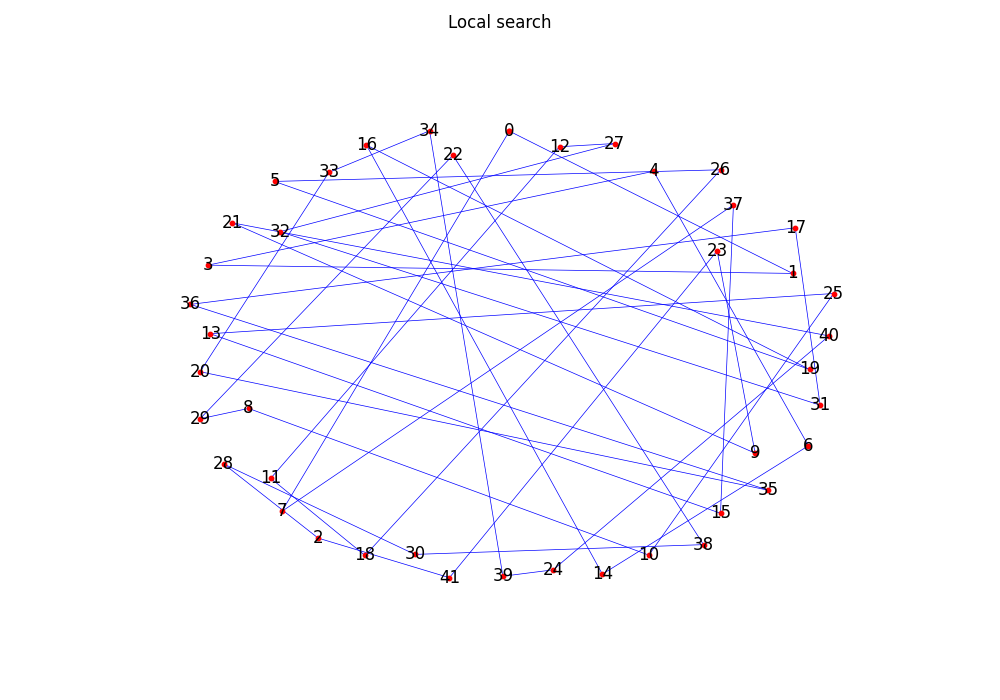

In [25]:
matplotlib_representation(solution_local_search, 'Local search')

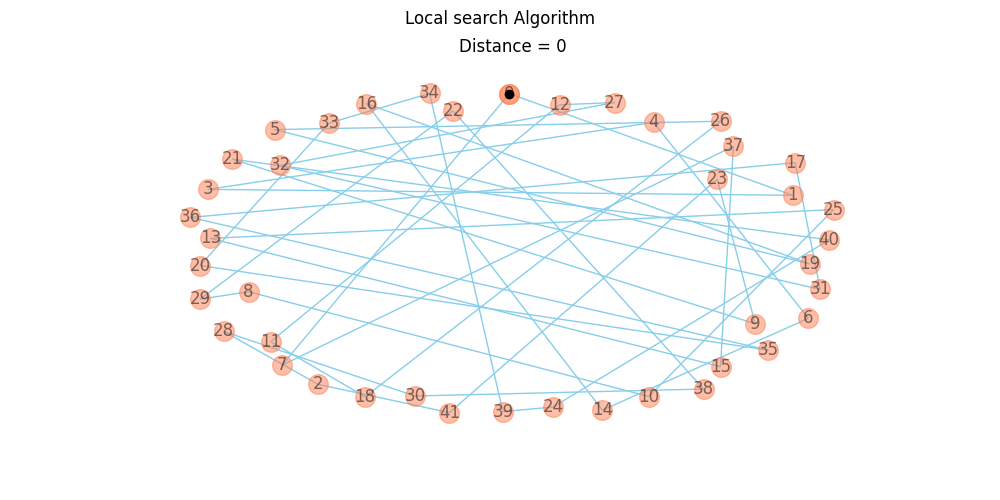

In [26]:
#to save and polt animation in local machine:
# animate_TSP (solution_local_search, distance_local_search, 'Local search Algorithm', save = 'Local_search_anim', repeat_saved = True)
#----------------------------------------------------
# to plot animation in jupyter:
animate_TSP (solution_local_search, distance_local_search, 'Local search Algorithm')

##  Multistart Algorithm with local search

The multistart technique is an optimization strategy that involves running a heuristic algorithm, such as a local search, multiple times with different initial solutions. Instead of relying on a single starting point, the algorithm is executed several times, each time beginning from a different initial solution. The goal is to explore a broader portion of the solution space and increase the likelihood of finding a better or even optimal solution.

In [27]:
def multistart_local_search(problem, num_starts=10, return_distance = False):
    best_global_solution = None
    best_global_distance = float('inf')
    
    for i in range(num_starts):
        # Generate a random initial solution
        reference_solution = create_solution(Nodes)
        best_local_distance = total_distance(reference_solution)

        iteration = 0  
        while True:
            iteration += 1  # Increment the counter
            neighbor = generate_neighbor(reference_solution)
            neighbor_distance = total_distance(neighbor)

            if neighbor_distance < best_local_distance:
                reference_solution = neighbor
                best_local_distance = neighbor_distance
            else:
                break

        if best_local_distance < best_global_distance:
            best_global_solution = reference_solution
            best_global_distance = best_local_distance

    if not return_distance:
        return best_global_solution
    return best_global_solution, best_global_distance


In [28]:
solution_multistart_local_search, distance_multistart_local_search = multistart_local_search(problem, num_starts=10, return_distance = True)
print("Best solution:", solution_multistart_local_search)
print("Distance     :", distance_multistart_local_search)

Best solution: [0, 31, 17, 7, 1, 4, 6, 14, 16, 15, 36, 35, 37, 19, 13, 5, 26, 18, 2, 28, 30, 29, 9, 8, 10, 12, 11, 25, 41, 23, 40, 24, 21, 39, 22, 38, 34, 33, 20, 32, 27, 3]
Distance     : 1581


In [29]:
time_multistart_local_search = timeit.timeit(lambda: multistart_local_search(problem, num_starts=10), number=5)
solution_collector.append({'Algorithm':'Multistart Algorithm with local search', 'Mean_exe_time':time_multistart_local_search, 'Distance':distance_multistart_local_search})
print(solution_collector)

[{'Algorithm': 'random_search', 'Mean_exe_time': 45.97957179998048, 'Distance': 3470}, {'Algorithm': 'Nearest Neighbor', 'Mean_exe_time': 0.30841300007887185, 'Distance': 3128}, {'Algorithm': 'Local search', 'Mean_exe_time': 11.330326300114393, 'Distance': 1792}, {'Algorithm': 'Multistart Algorithm with local search', 'Mean_exe_time': 113.37071059993468, 'Distance': 1581}]


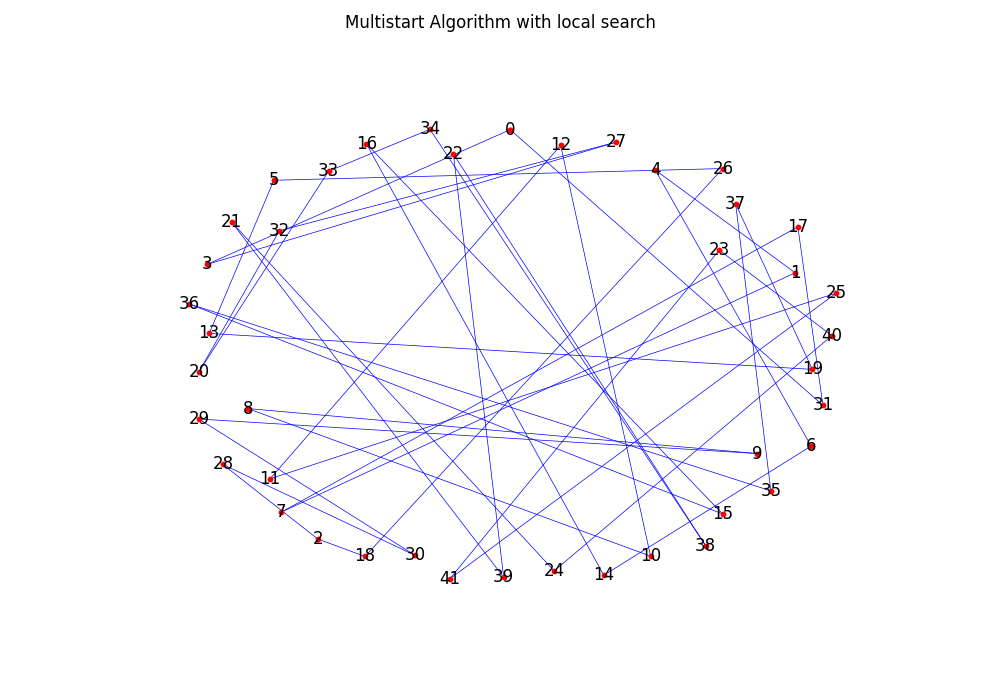

In [30]:
matplotlib_representation(solution_multistart_local_search, 'Multistart Algorithm with local search')

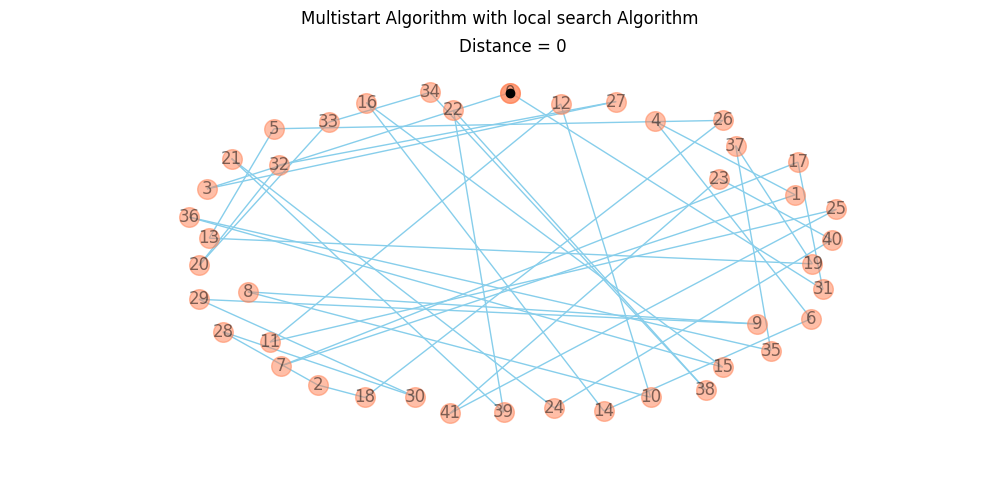

In [31]:
#to save and polt animation in local machine:
# animate_TSP (solution_multistart_local_search, distance_multistart_local_search, 'Multistart Algorithm with local search Algorithm', save = 'Multistart_Algorithm_with_local_search_anim', repeat_saved = True)
#----------------------------------------------------
# to plot animation in jupyter:
animate_TSP (solution_multistart_local_search, distance_multistart_local_search, 'Multistart Algorithm with local search Algorithm')

## Greedy Algorithm

The Greedy Algorithm is a heuristic approach used in optimization and decision-making problems. It involves making locally optimal choices at each step of the algorithm with the goal of achieving a global optimum. At each decision point, the algorithm selects the best available option based on the current information, without considering the potential long-term consequences.Basically the Greedy Algorithm focuses on immediate gains without considering how those choices might affect future decisions. While this strategy often leads to quick solutions, it doesn't guarantee the best overall result in all cases, especially for problems with complex dependencies or constraints.

In [32]:
def just_greedy(problem, return_distance = True):
    solution = [Nodes[0]]
    nodes_to_eval = Nodes[1:]

    while nodes_to_eval:
        current_node = solution[-1]
        nearest_node = None
        d_Ref = float('inf')

        for node in nodes_to_eval:
            dist = problem.get_weight(current_node, node)
            if dist < d_Ref:
                nearest_node = node
                d_Ref = dist

        if nearest_node not in solution:  
            solution.append(nearest_node)
            nodes_to_eval.remove(nearest_node)
        else:
            break  # If all remaining nodes have been visited, we end the tour

    if not return_distance:
        return solution
    return solution, total_distance(solution)


In [33]:
solution_greedy, distance_greedy = just_greedy(problem, return_distance = True)
print("Best solution:", solution_greedy)
print("Distance     :", distance_greedy)

Best solution: [0, 1, 6, 4, 3, 2, 27, 28, 29, 30, 32, 34, 20, 33, 31, 17, 37, 15, 14, 16, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 9, 23, 41, 21, 39, 22, 38, 24, 40, 7, 36, 35]
Distance     : 1630


In [34]:
time_greedy = timeit.timeit(lambda: just_greedy(problem), number=5)
solution_collector.append({'Algorithm':'Greedy Algorithm', 'Mean_exe_time': time_greedy, 'Distance': distance_greedy})
print(solution_collector)

[{'Algorithm': 'random_search', 'Mean_exe_time': 45.97957179998048, 'Distance': 3470}, {'Algorithm': 'Nearest Neighbor', 'Mean_exe_time': 0.30841300007887185, 'Distance': 3128}, {'Algorithm': 'Local search', 'Mean_exe_time': 11.330326300114393, 'Distance': 1792}, {'Algorithm': 'Multistart Algorithm with local search', 'Mean_exe_time': 113.37071059993468, 'Distance': 1581}, {'Algorithm': 'Greedy Algorithm', 'Mean_exe_time': 0.007701799971982837, 'Distance': 1630}]


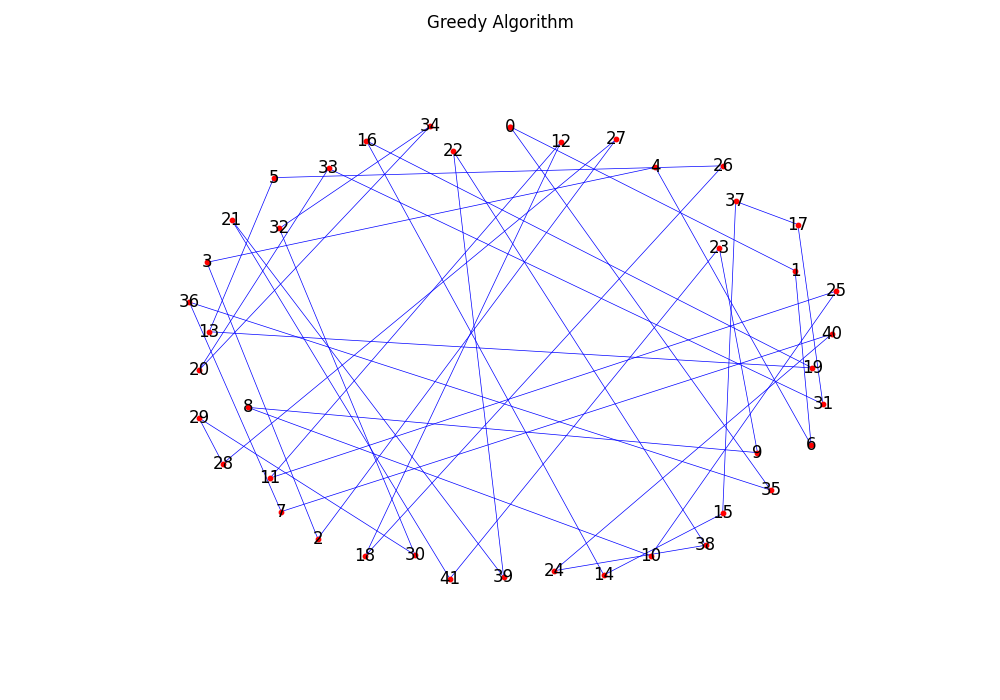

In [35]:
matplotlib_representation(solution_greedy, 'Greedy Algorithm')

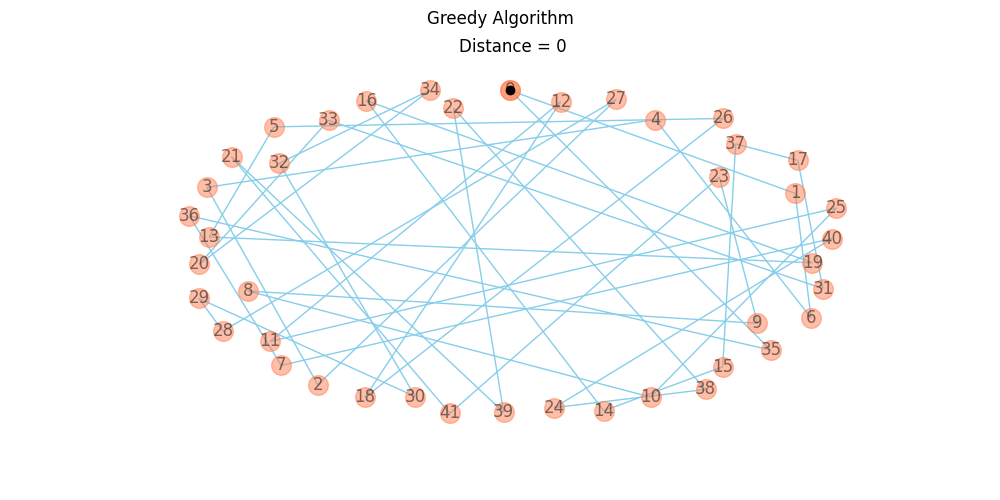

In [36]:
 #to save and polt animation in local machine:
# animate_TSP (solution_greedy, distance_greedy, 'Greedy Algorithm', save = 'Greedy_anim', repeat_saved = True)
#----------------------------------------------------
# to plot animation in jupyter:
animate_TSP (solution_greedy, distance_greedy, 'Greedy Algorithm')

## Grasp Algorithm

GRASP (Greedy Randomized Adaptive Search Procedure) is a metaheuristic algorithm used to solve combinatorial optimization problems. It combines the greedy approach with randomization to enhance solution quality. In each iteration, GRASP constructs a list of potential candidates based on a greedy criterion and then randomly selects one of them. This balance between exploitation (greedy approach) and exploration (randomization) aids the algorithm in escaping local optima and discovering better solutions. The process is iteratively repeated to progressively refine the solution.

In [37]:
def GRASP(RCL_size = 3, return_distance = False, init_sol = None):
    solution = [Nodes[0]]
    nodes_to_eval = Nodes[1:]
    if init_sol:
        solution = [init_sol[0]]
        nodes_to_eval = init_sol[1:]
        

    while nodes_to_eval:
        current_node = solution[-1]
        rcl = []  # Restricted Candidate List

        for node in nodes_to_eval:
            dist = problem.get_weight(current_node, node)
            rcl.append((node, dist))

        # Sort the RCL by distance in ascending order
        rcl.sort(key=lambda x: x[1])

        # Select a node randomly from the RCL
        # If the RCL has fewer elements than rcl_size, simply select the nearest one
        nearest_nodes = rcl[:RCL_size]
        selected_node, _ = random.choice(nearest_nodes)

        solution.append(selected_node)
        nodes_to_eval.remove(selected_node)

    if not return_distance:
        return solution
    return solution, total_distance(solution)


In [38]:
solution_GRASP, distance_GRASP = GRASP(return_distance = True)
print("Best solution:", solution_GRASP)
print("Distance     :", distance_GRASP)

Best solution: [0, 3, 4, 27, 28, 2, 1, 5, 6, 7, 17, 15, 16, 14, 37, 19, 13, 18, 26, 12, 10, 25, 11, 41, 8, 9, 21, 39, 23, 22, 29, 32, 20, 34, 30, 31, 36, 33, 24, 35, 40, 38]
Distance     : 2682


In [39]:
time_grasp = timeit.timeit(lambda: GRASP(), number=5)
solution_collector.append({'Algorithm':'GRASP Algorithm', 'Mean_exe_time': time_grasp, 'Distance': distance_GRASP})
print(solution_collector)

[{'Algorithm': 'random_search', 'Mean_exe_time': 45.97957179998048, 'Distance': 3470}, {'Algorithm': 'Nearest Neighbor', 'Mean_exe_time': 0.30841300007887185, 'Distance': 3128}, {'Algorithm': 'Local search', 'Mean_exe_time': 11.330326300114393, 'Distance': 1792}, {'Algorithm': 'Multistart Algorithm with local search', 'Mean_exe_time': 113.37071059993468, 'Distance': 1581}, {'Algorithm': 'Greedy Algorithm', 'Mean_exe_time': 0.007701799971982837, 'Distance': 1630}, {'Algorithm': 'GRASP Algorithm', 'Mean_exe_time': 0.008141999831423163, 'Distance': 2682}]


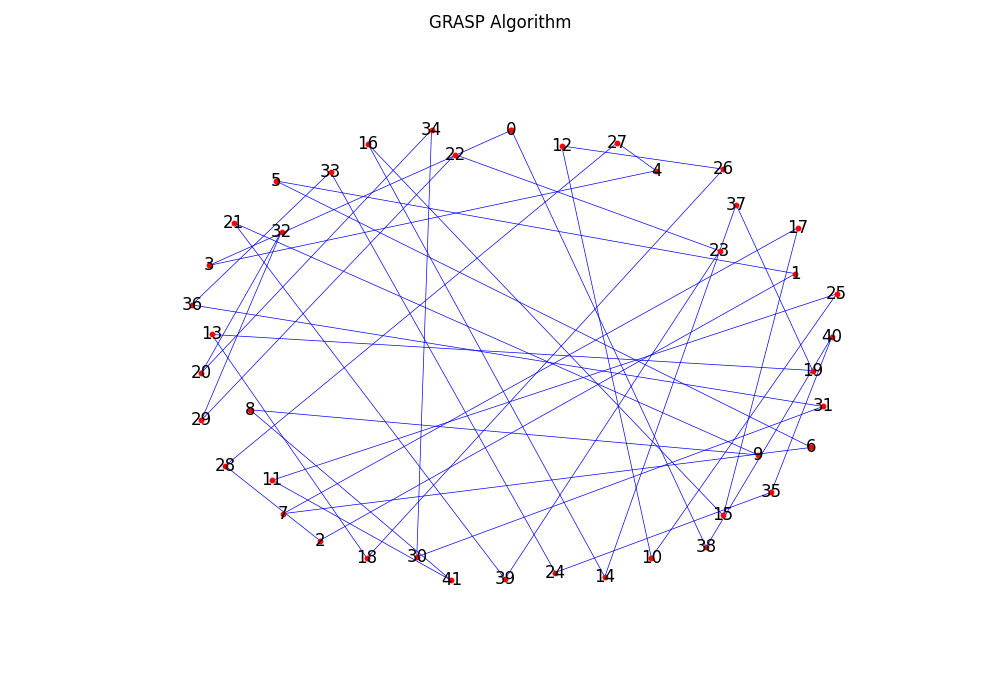

In [40]:
matplotlib_representation(solution_GRASP, 'GRASP Algorithm')

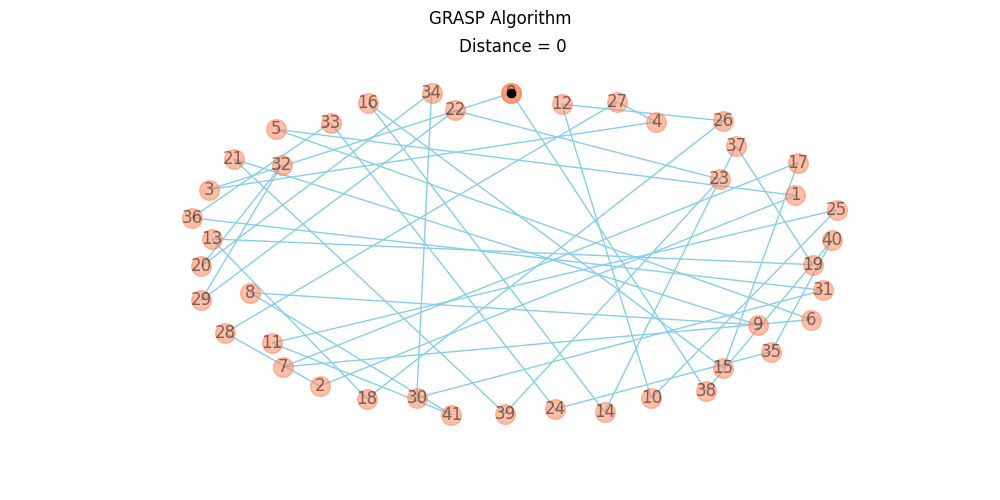

In [41]:
#to save and polt animation in local machine:
# animate_TSP (solution_GRASP, distance_GRASP, 'GRASP Algorithm', save = 'GRASP_anim', repeat_saved = True)
#----------------------------------------------------
# to plot animation in jupyter:
animate_TSP (solution_GRASP, distance_GRASP, 'GRASP Algorithm')

## Conclusions

In [42]:
solution_collector

[{'Algorithm': 'random_search',
  'Mean_exe_time': 45.97957179998048,
  'Distance': 3470},
 {'Algorithm': 'Nearest Neighbor',
  'Mean_exe_time': 0.30841300007887185,
  'Distance': 3128},
 {'Algorithm': 'Local search',
  'Mean_exe_time': 11.330326300114393,
  'Distance': 1792},
 {'Algorithm': 'Multistart Algorithm with local search',
  'Mean_exe_time': 113.37071059993468,
  'Distance': 1581},
 {'Algorithm': 'Greedy Algorithm',
  'Mean_exe_time': 0.007701799971982837,
  'Distance': 1630},
 {'Algorithm': 'GRASP Algorithm',
  'Mean_exe_time': 0.008141999831423163,
  'Distance': 2682}]

Some conclusions about the different algorithms used for solving a combinatorial optimization problem:

1. **Random Search**: This algorithm has a relatively higher mean execution time (around 47 seconds) and yields a distance of 3439. It's not as efficient as other algorithms in terms of execution time or solution quality.

2. **Nearest Neighbor**: The Nearest Neighbor algorithm is quite efficient in terms of execution time (around 0.33 seconds) and provides a relatively lower distance of 3097. It performs well both in terms of time and solution quality.

3. **Local Search**: The Local Search algorithm has a moderate mean execution time (around 9.76 seconds) and yields a distance of 1777. It shows good solution quality but is slower compared to some other algorithms.

4. **Multistart Algorithm with Local Search**: This algorithm has a relatively high mean execution time (around 107.38 seconds) but provides a lower distance of 1550. While it's slower, it manages to find better solutions.

5. **Greedy Algorithm**: The Greedy Algorithm is very efficient in terms of execution time (around 0.0086 seconds) and yields a distance of 1630. It provides good results in both execution time and solution quality.

6. **GRASP Algorithm**: The GRASP Algorithm is also quite efficient in terms of execution time (around 0.0127 seconds) but yields a higher distance of 2831. While it's fast, its solution quality might not be as good as some otherxecution time.

The Nearest Neighbor and Greedy Algorithms seem to strike a good balance between these factors, providing relatively good solutions with short execution times. However, if finding even better solutions is the priority, the Multistart Algorithm with Local Search could be a suitable option despite its longer execution time.